In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# converse MNIST -> Tensor

In [5]:
transform = transforms.ToTensor()

In [8]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform) # train data from MNIST

In [9]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform) # test data from MNIST

In [10]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [11]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [12]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [13]:
type(train_data[0])

tuple

In [14]:
image, label = train_data[0]

In [15]:
image.shape

torch.Size([1, 28, 28])

In [16]:
label

5

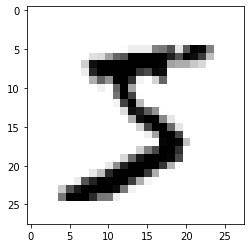

In [21]:
plt.imshow(image.reshape((28, 28)), cmap='gist_yarg')

In [80]:
torch.manual_seed(101) # Sets the seed for generating random numbers - buoc cbi de tao ngau nhien

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [81]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # formatting

In [82]:
# 1st batch
for images, labels in train_loader:
    break

In [83]:
images.shape

torch.Size([100, 1, 28, 28])

In [84]:
labels.shape

torch.Size([100])

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


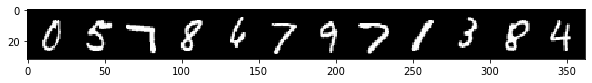

In [85]:
# in 12 labels dau tien
print('Labels: ', labels[:12].numpy())

# in 12 anh dau tien
img = make_grid(images[:12], nrow=12) # nrow mac dinh = 8
plt.figure(figsize=(10, 4))

# Hoan vi anh tu CWH -> WHC
plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # (1, 2, 0) la index cua [1, 28, 28] images.shape -> [28, 28, 1]

In [86]:
class MultilayerPerceptron(nn.Module):
    
    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]): # 784 = 28*28
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1) # multi class classification

In [87]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [88]:
# ANN -> CNN
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [89]:
# tong 105214 params 

In [90]:
crit = nn.CrossEntropyLoss()
learning_rate = 0.001
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
images.shape # -> [100, 784]

torch.Size([100, 1, 28, 28])

In [92]:
images.view(128, -1).shape # 100 = batch_size cua train_loader

RuntimeError: shape '[128, -1]' is invalid for input of size 78400

In [94]:
import time
start_time = time.time()

# Training
epochs = 10

# Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b += 1
        
        # 10 neurons === 10 classes
        y_pred = model(X_train.view(100, -1))
        loss = crit(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if b % 200 == 0:
            accuracy = trn_corr.item() * 100 / (100 * b)
            print(f'Epoch {i} - batch {b} - loss: {loss.item()} - accuracy: {accuracy}')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            y_val = model(X_test.view(500, -1)) # 500 = batch_size cua test_loader
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = crit(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        

total_time = time.time() - start_time
print(f'Train trong: {total_time} giay')

Epoch 0 - batch 200 - loss: 0.005704420618712902 - accuracy: 99.555
Epoch 0 - batch 400 - loss: 0.0041642263531684875 - accuracy: 99.4825
Epoch 0 - batch 600 - loss: 0.10030805319547653 - accuracy: 99.39666666666666
Epoch 1 - batch 200 - loss: 0.03371325135231018 - accuracy: 99.63
Epoch 1 - batch 400 - loss: 0.023873714730143547 - accuracy: 99.57
Epoch 1 - batch 600 - loss: 0.015323251485824585 - accuracy: 99.50833333333334
Epoch 2 - batch 200 - loss: 0.005028479266911745 - accuracy: 99.595
Epoch 2 - batch 400 - loss: 0.012982173822820187 - accuracy: 99.46
Epoch 2 - batch 600 - loss: 0.08433325588703156 - accuracy: 99.45833333333333
Epoch 3 - batch 200 - loss: 0.008687845431268215 - accuracy: 99.64
Epoch 3 - batch 400 - loss: 0.015124164521694183 - accuracy: 99.65
Epoch 3 - batch 600 - loss: 0.015657171607017517 - accuracy: 99.59833333333333
Epoch 4 - batch 200 - loss: 0.0031726271845400333 - accuracy: 99.765
Epoch 4 - batch 400 - loss: 0.0019273469224572182 - accuracy: 99.665
Epoch 4 

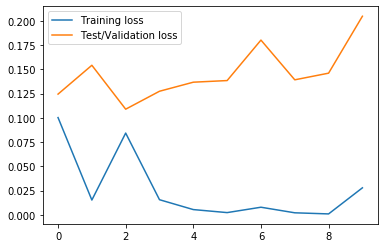

In [95]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test/Validation loss')
plt.legend()

In [96]:
train_accuracy = [t / 600 for t in train_correct]

In [97]:
test_accuracy = [t / 100 for t in test_correct]

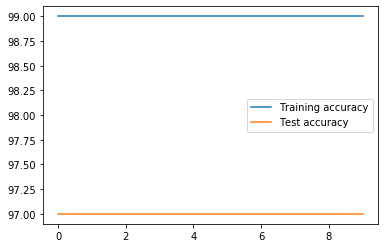

In [98]:
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(test_accuracy, label='Test accuracy')
plt.legend()

In [99]:
# New data

test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [100]:
with torch.no_grad():
    
    correct = 0
    
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [101]:
correct.item() / len(test_data) * 100

97.45

In [102]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 973,    0,    2,    0,    1,    2,    4,    1,    7,    1],
       [   0, 1121,    1,    0,    0,    0,    3,    3,    0,    3],
       [   0,    3, 1005,    6,    1,    0,    1,    8,    1,    0],
       [   0,    0,    2,  968,    1,   19,    1,    1,    0,    0],
       [   0,    0,    2,    1,  956,    2,    4,    0,    3,    2],
       [   0,    0,    0,    0,    0,  832,    1,    0,    0,    2],
       [   1,    2,    2,    0,    4,   14,  943,    0,    1,    0],
       [   0,    1,    2,    6,    1,    2,    0,  999,    2,    3],
       [   4,    8,   14,   17,    1,   17,    1,    7,  956,    6],
       [   2,    0,    2,   12,   17,    4,    0,    9,    4,  992]])

In [103]:
# MISSES

In [104]:
misses =np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses, i).astype('int64')
len(misses)

255

In [105]:
misses[:10]

array([  18,  115,  149,  247,  259,  320,  321,  340,  381,  445])

In [106]:
r = 12
row = iter(np.array_split(misses, len(misses) // r + 1))

Index:  [  18  115  149  247  259  320  321  340  381  445  447  448]
Label:  [   3    4    2    4    6    9    2    5    3    6    4    9]
Guess:  [   8    9    9    6    0    8    7    3    7    0    9    8]


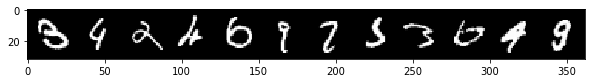

In [107]:
next_row = next(row)
print('Index: ', next_row)
print('Label: ', y_test.index_select(0, torch.tensor(next_row)).numpy())
print('Guess: ', predicted.index_select(0, torch.tensor(next_row)).numpy())

images = X_test.index_select(0, torch.tensor(next_row))
img = make_grid(images, nrow=r)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))